In [2]:
import pandas as pd
import numpy as np
import string
import scipy as sp
from math import ceil
import seaborn as sns
from glob import glob
from Bio import pairwise2, SeqIO, Seq
import ternary
from matplotlib_venn import venn2_unweighted, venn3, venn3_circles, venn3_unweighted
import gffpandas.gffpandas as gffpd
import matplotlib.pyplot as plt
import matplotlib.font_manager
import copy
import pycircos
from Bio.SeqUtils import GC
import textwrap
import math
import matplotlib.gridspec as gridspec

matplotlib.rcParams["font.family"] = "Arial"

ROW_LEN = 5
COL_LEN = 9
samples = sorted([ y + str(x) for x in range(1,COL_LEN+1) for y in list(string.ascii_uppercase)[:ROW_LEN] ])

In [3]:
prep_df = pd.read_csv('../../01-INPUT/01-META/eLW008-library_prep_data_melted.csv')
extraction_df = pd.read_csv('../../01-INPUT/01-META/eLW008-extraction_data_melted.csv')
pool_df = pd.read_csv('../../01-INPUT/01-META/eLW008-pool_map_melted.csv')
layout_df = pd.read_csv('../../01-INPUT/01-META/eLW008-layout_melted.csv')

layout_df['condition'] = layout_df['condition'].apply(lambda x: x.replace('+','_'))
layout_df['well'] = layout_df['row'] + layout_df['column'].astype(str)

extraction_df = layout_df.merge(extraction_df,on=['row','column'])
biovar_map = {"sLW002":"BV1",
              "sLW005":"BV2",
              "sLW006":"BV3"}
strain_map = {'sLW002':'C58','sLW005':'C16_80','sLW006':'T60_94'}
carbon_source_map = {'MOPS_glucose':'glucose',
 'MOPS_succinate':'succinate',
 'MGYS_exponential':'mannitol',
 'MGYS_induction':'mannitol',
 'MGYS_stationary':'mannitol'}

extraction_df['biovar'] = extraction_df['strain'].map(biovar_map)
extraction_df['strain'] = extraction_df['strain'].map(strain_map)
extraction_df['carbon_source'] = extraction_df['condition'].map(carbon_source_map)
extraction_df['biovar-replicate'] = extraction_df['biovar'] + '-' + extraction_df['replicate'].astype(str)
extraction_df['biovar-condition'] = extraction_df['biovar'] + '-' + extraction_df['condition'].astype(str)
extraction_df = extraction_df.merge(pool_df,on='well')
prep_df = prep_df.merge(pool_df,on='sample')
prep_df = prep_df.merge(extraction_df[['biovar-condition','biovar-replicate','sample']],on='sample')


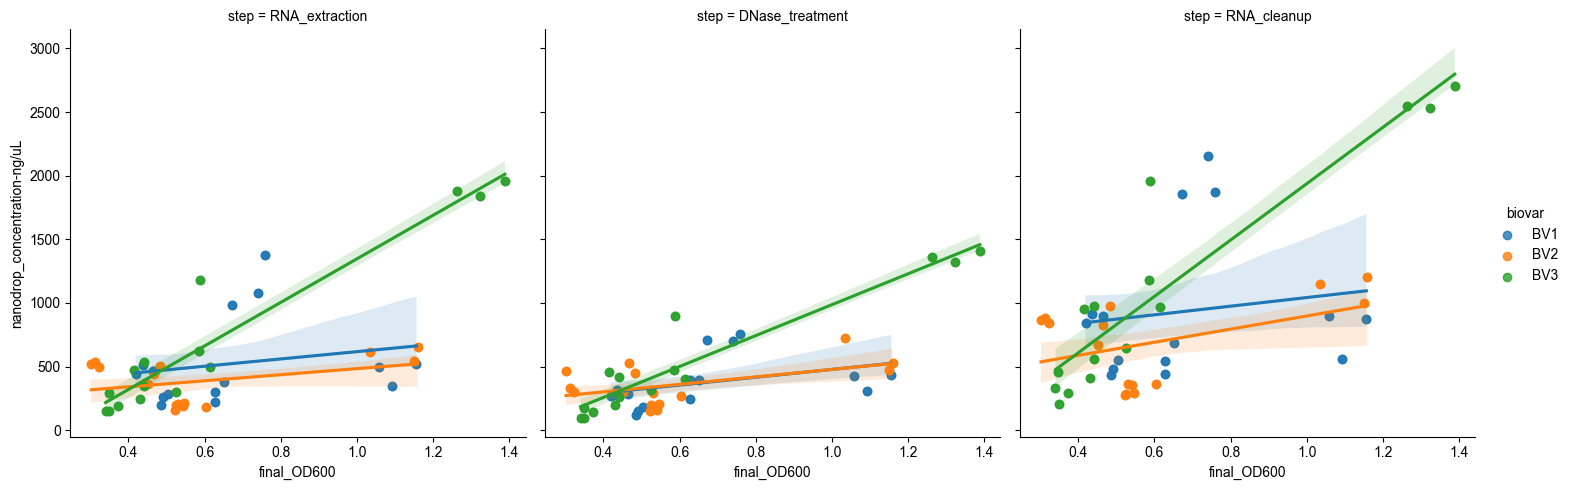

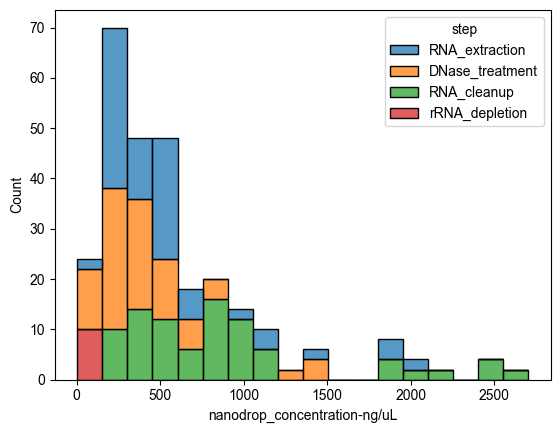

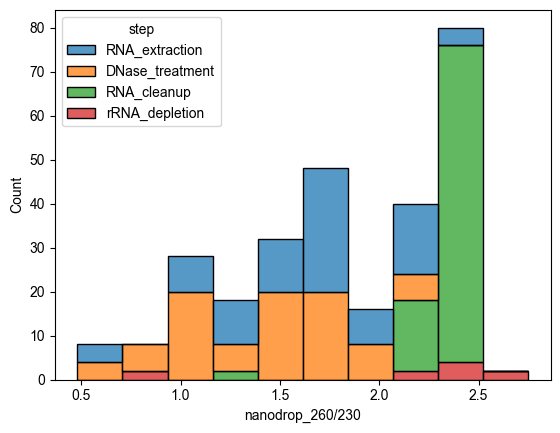

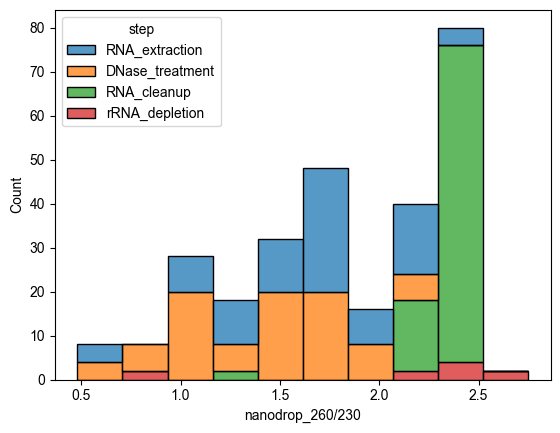

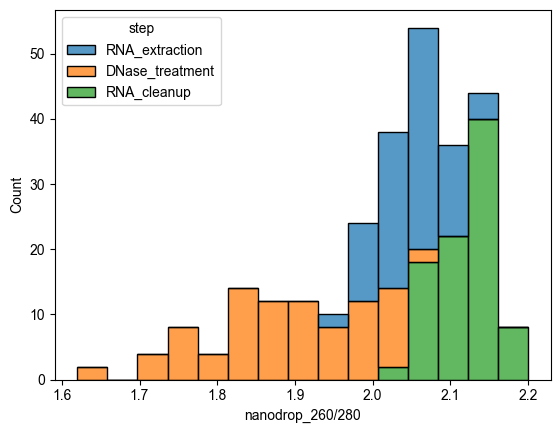

In [4]:
sns.lmplot(data=extraction_df.query('step != "rRNA_depletion"'),x='final_OD600',y='nanodrop_concentration-ng/uL',col='step',hue='biovar')
plt.show()

sns.histplot(data=extraction_df,x='nanodrop_concentration-ng/uL',hue='step',multiple='stack')
plt.show()

sns.histplot(data=extraction_df,x='nanodrop_260/230',hue='step',multiple='stack')
plt.show()

sns.histplot(data=extraction_df,x='nanodrop_260/230',hue='step',multiple='stack')
plt.show()

sns.histplot(data=extraction_df.query('step != "rRNA_depletion"'),x='nanodrop_260/280',hue='step',multiple='stack')
plt.show()

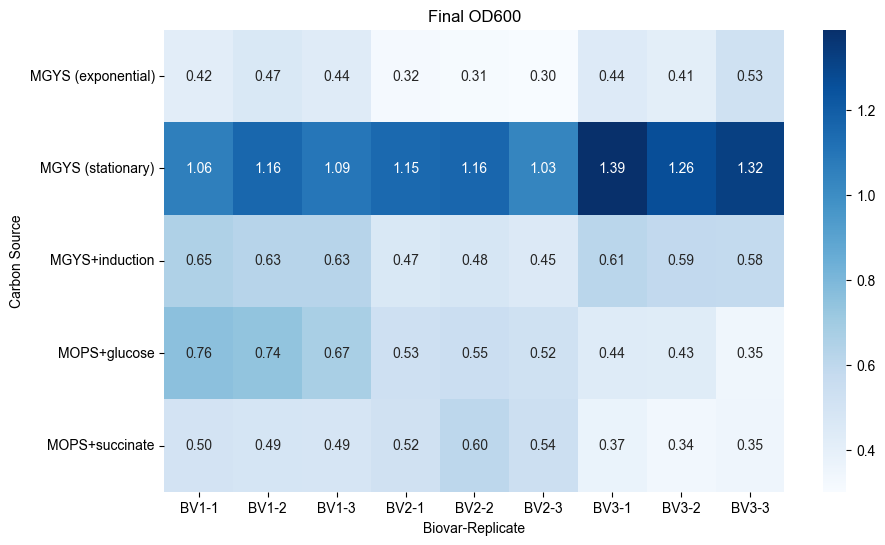

In [5]:
condition_mapper = {
    'MOPS_glucose':'MOPS+glucose', 
    'MOPS_succinate':'MOPS+succinate', 
    'MGYS_exponential':'MGYS (exponential)',
    'MGYS_induction':'MGYS+induction', 
    'MGYS_stationary':'MGYS (stationary)'
}
tmp = extraction_df.query("step == 'RNA_cleanup' and TEX_treated == False").copy()
tmp['condition'] = tmp['condition'].map(condition_mapper)

fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(tmp.pivot(columns='biovar-replicate',index='condition',values='final_OD600'), annot=True, fmt=".2f", ax=ax,cmap=sns.color_palette("Blues", as_cmap=True))
plt.yticks(rotation=0) 
plt.title("Final OD600")
plt.xlabel('Biovar-Replicate')
plt.ylabel('Carbon Source')
plt.savefig("../../02-OUTPUT/06-ANALYSIS/si_OD600.png",dpi=300,bbox_inches='tight')
plt.show()

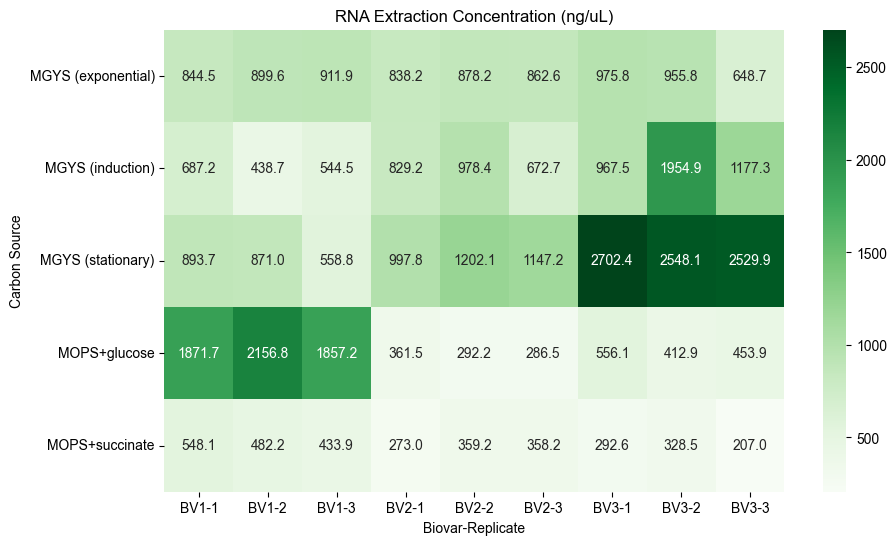

In [6]:
condition_mapper = {
    'MOPS_glucose':'MOPS+glucose', 
    'MOPS_succinate':'MOPS+succinate', 
    'MGYS_exponential':'MGYS (exponential)',
    'MGYS_induction':'MGYS (induction)', 
    'MGYS_stationary':'MGYS (stationary)'
}
tmp = extraction_df.query("step == 'RNA_cleanup' and TEX_treated == False").copy()
tmp['condition'] = tmp['condition'].map(condition_mapper)

fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(tmp.pivot(columns='biovar-replicate',index='condition',values='nanodrop_concentration-ng/uL'), annot=True, fmt=".1f", ax=ax,cmap=sns.color_palette("Greens", as_cmap=True))
plt.yticks(rotation=0) 
plt.title("RNA Extraction Concentration (ng/uL)")
plt.xlabel('Biovar-Replicate')
plt.ylabel('Carbon Source')
plt.savefig("../../02-OUTPUT/06-ANALYSIS/si_RNA_concentration.png",dpi=300,bbox_inches='tight')
plt.show()


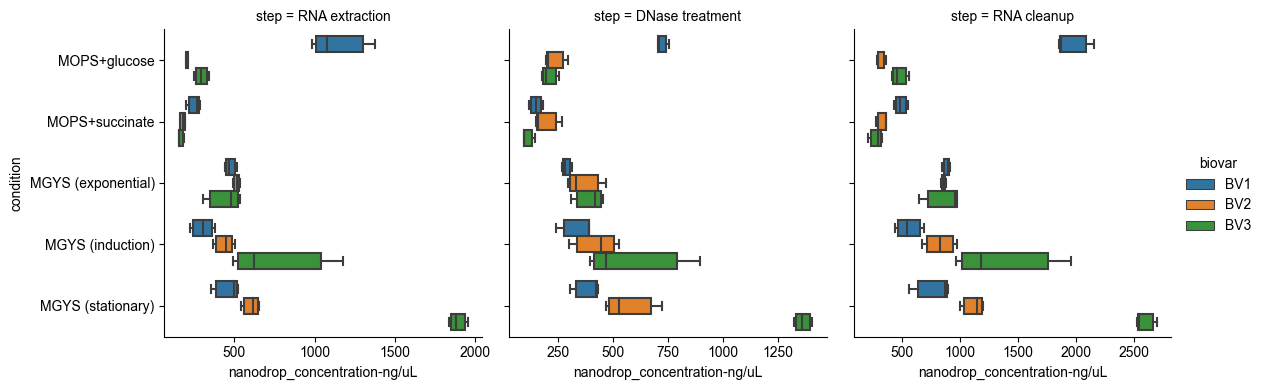

In [7]:
condition_mapper = {
    'MOPS_glucose':'MOPS+glucose', 
    'MOPS_succinate':'MOPS+succinate', 
    'MGYS_exponential':'MGYS (exponential)',
    'MGYS_induction':'MGYS (induction)', 
    'MGYS_stationary':'MGYS (stationary)'
}
step_mapper = {
    'RNA_extraction':'RNA extraction','DNase_treatment':'DNase treatment', 'RNA_cleanup':'RNA cleanup'
}
tmp = extraction_df.query('step != "rRNA_depletion"').copy()
tmp['condition'] = tmp['condition'].map(condition_mapper)
tmp['step'] = tmp['step'].map(step_mapper)
tmp['step'] = tmp['step'].astype('category').cat.reorder_categories(['RNA extraction','DNase treatment','RNA cleanup'])

g = sns.catplot(tmp,y='condition',x='nanodrop_concentration-ng/uL',hue='biovar',col='step',height=4,aspect=1,kind="box",sharex=False)
g.savefig('../../02-OUTPUT/06-ANALYSIS/si_lib_prep.png',dpi=300)

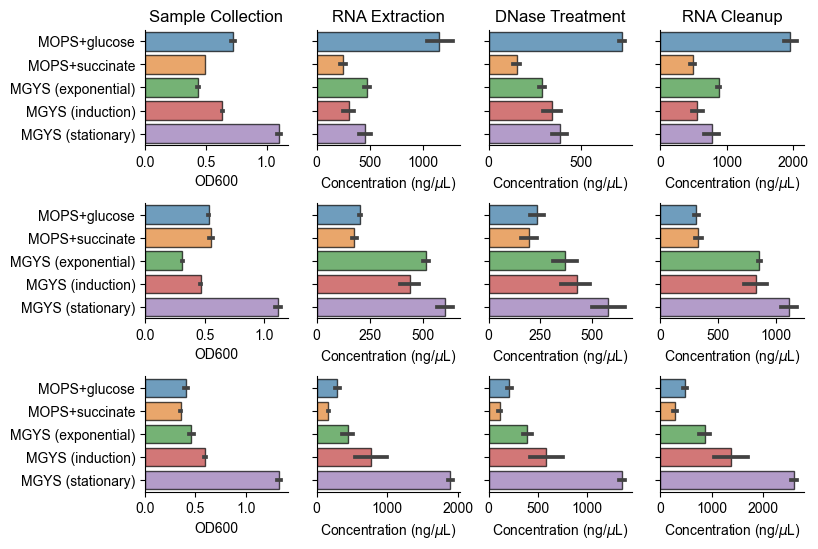

In [26]:
sns.set_context(rc = {'legend.fontsize': 10, 'ytick.labelsize': 10, 'xtick.labelsize':10, 'axes.labelsize':10})

fig = plt.figure(figsize=(8.5,6))
gs = gridspec.GridSpec(3,4,hspace=0.5)

query = tmp.query("biovar == 'BV1'")
ax = fig.add_subplot(gs[0, 0])
g = sns.barplot(data=query,y='condition',x='final_OD600',ax=ax,edgecolor="black",linewidth=1.0,alpha=0.7)
g.set_ylabel(None)
g.set_xlabel('OD600')
g.set_title('Sample Collection')
sns.despine()
g = sns.barplot(query.query("step == 'RNA extraction'"),y='condition',x='nanodrop_concentration-ng/uL',ax=fig.add_subplot(gs[0, 1]),edgecolor="black",linewidth=1.0,alpha=0.7)
g.set(yticklabels=[])
g.set_ylabel(None)
g.set_xlabel(r'Concentration (ng/$\mu$L)')
g.set_title('RNA Extraction')
sns.despine()
g = sns.barplot(query.query("step == 'DNase treatment'"),y='condition',x='nanodrop_concentration-ng/uL',ax=fig.add_subplot(gs[0, 2]),edgecolor="black",linewidth=1.0,alpha=0.7)
g.set(yticklabels=[])
g.set_ylabel(None)
g.set_xlabel(r'Concentration (ng/$\mu$L)')
g.set_title('DNase Treatment')
sns.despine()
g = sns.barplot(query.query("step == 'RNA cleanup'"),y='condition',x='nanodrop_concentration-ng/uL',ax=fig.add_subplot(gs[0, 3]),edgecolor="black",linewidth=1.0,alpha=0.7)
g.set(yticklabels=[])
g.set_ylabel(None)
g.set_xlabel(r'Concentration (ng/$\mu$L)')
g.set_title('RNA Cleanup')
sns.despine()

query = tmp.query("biovar == 'BV2'")
ax = fig.add_subplot(gs[1, 0])
g = sns.barplot(data=query,y='condition',x='final_OD600',ax=ax,edgecolor="black",linewidth=1.0,alpha=0.7)
g.set_ylabel(None)
g.set_xlabel('OD600')
sns.despine()
g = sns.barplot(query.query("step == 'RNA extraction'"),y='condition',x='nanodrop_concentration-ng/uL',ax=fig.add_subplot(gs[1, 1]),edgecolor="black",linewidth=1.0,alpha=0.7)
g.set(yticklabels=[])
g.set_ylabel(None)
g.set_xlabel(r'Concentration (ng/$\mu$L)')
sns.despine()
g = sns.barplot(query.query("step == 'DNase treatment'"),y='condition',x='nanodrop_concentration-ng/uL',ax=fig.add_subplot(gs[1, 2]),edgecolor="black",linewidth=1.0,alpha=0.7)
g.set(yticklabels=[])
g.set_ylabel(None)
g.set_xlabel(r'Concentration (ng/$\mu$L)')
sns.despine()
g = sns.barplot(query.query("step == 'RNA cleanup'"),y='condition',x='nanodrop_concentration-ng/uL',ax=fig.add_subplot(gs[1, 3]),edgecolor="black",linewidth=1.0,alpha=0.7)
g.set(yticklabels=[])
g.set_ylabel(None)
g.set_xlabel(r'Concentration (ng/$\mu$L)')
sns.despine()

query = tmp.query("biovar == 'BV3'")
ax = fig.add_subplot(gs[2, 0])
g = sns.barplot(data=query,y='condition',x='final_OD600',ax=ax,edgecolor="black",linewidth=1.0,alpha=0.7)
g.set_ylabel(None)
g.set_xlabel('OD600')
sns.despine()

g = sns.barplot(query.query("step == 'RNA extraction'"),y='condition',x='nanodrop_concentration-ng/uL',ax=fig.add_subplot(gs[2, 1]),edgecolor="black",linewidth=1.0,alpha=0.7)
g.set(yticklabels=[])
g.set_ylabel(None)
g.set_xlabel(r'Concentration (ng/$\mu$L)')
sns.despine()
g = sns.barplot(query.query("step == 'DNase treatment'"),y='condition',x='nanodrop_concentration-ng/uL',ax=fig.add_subplot(gs[2, 2]),edgecolor="black",linewidth=1.0,alpha=0.7)
g.set(yticklabels=[])
g.set_ylabel(None)
g.set_xlabel(r'Concentration (ng/$\mu$L)')
sns.despine()
g = sns.barplot(query.query("step == 'RNA cleanup'"),y='condition',x='nanodrop_concentration-ng/uL',ax=fig.add_subplot(gs[2, 3]),edgecolor="black",linewidth=1.0,alpha=0.7)
g.set(yticklabels=[])
g.set_xlabel(r'Concentration (ng/$\mu$L)')
g.set_ylabel(None)
sns.despine()

plt.savefig("../../02-OUTPUT/06-ANALYSIS/02-library_prep.png",dpi=600,bbox_inches='tight',transparent=True)

In [ ]:
query

In [ ]:
tmp['condition'] = tmp['condition'].astype('category')



conditions_df['contig'] = conditions_df['contig']
conditions_df['contig'] = conditions_df['contig'].cat.set_categories(['MOPS+glucose', 'MOPS+succinate', 'MGYS (exponential)',
       'MGYS+induction', 'MGYS (stationary)' ], ordered=True)

In [ ]:
sns.relplot(data=prep_df.query('step == "RNA_cleanup"'),hue='run',y='biovar-condition',x='concentration-ng/uL',height=4,aspect=1.5)
plt.show()

In [ ]:
sns.relplot(data=prep_df.query('run == "C" and step == "Qubit"'),x='concentration-ng/uL',y='biovar-condition',hue='TEX_treated',aspect=1.3)
plt.show()

In [ ]:
seq_df = pd.read_csv('../../01-INPUT/01-META/eLW008-library_stats.csv')

In [ ]:
sns.relplot(data=seq_df,x='perfect_barcode_percent',y='biovar-condition',aspect=1.3,hue='TEX_treated')
plt.show()
sns.relplot(data=seq_df,x='one_mismatch_barcode_percent',y='biovar-condition',aspect=1.3,hue='TEX_treated')
plt.show()
sns.relplot(data=seq_df,x='yield-Mbases',y='biovar-condition',aspect=1.3,hue='TEX_treated')
plt.show()
sns.relplot(data=seq_df,x='pf_clusters_percent',y='biovar-condition',aspect=0.3,hue='TEX_treated')
plt.show()
sns.relplot(data=seq_df,x='q30_filter_percent',y='biovar-condition',aspect=1.3,hue='TEX_treated')
plt.show()
sns.relplot(data=seq_df,x='mean_quality_score',y='biovar-condition',aspect=1.3,hue='TEX_treated')
plt.show()

In [ ]:
# result = prep_df.query('run == "C" and step == "RNA_cleanup"').reset_index(drop=True)
# result.index += 1 
# DESIRED_VOLUME_uL = 1
# DESIRED_MASS_ng = 2500
# result['result'] = result['concentration-ng/uL'].apply(lambda x: (DESIRED_VOLUME_uL * DESIRED_MASS_ng) / (x)).apply(lambda y: ceil(y * 10) / 10.0)
# display(result['result'] * 2)

In [3]:
genome_stats = {'BV1':{},'BV2':{},'BV3':{}}

for biovar in genome_stats.keys():
    fasta_path = glob(f'../../01-INPUT/04-REFERENCE/{biovar}*.fna')
    assert len(fasta_path) == 1
    fastas = SeqIO.parse(open(fasta_path[0]),'fasta')
    
    chromosomes = {}
    for fasta in fastas:
        chromosomes[fasta.id] = str(fasta.seq)
    genome_stats[biovar] = chromosomes

fna_df = pd.DataFrame.from_dict(genome_stats,orient='index').unstack().reset_index().dropna().reset_index(drop=True)
fna_df.columns = ['name','biovar','sequence']
fna_df['sequence_GC'] = fna_df['sequence'].apply(lambda x: GC(x))
fna_df['sequence_len'] = fna_df['sequence'].apply(lambda x: len(x))
fna_df.to_csv('../../02-OUTPUT/06-ANALYSIS/table1.csv',index=False)

,name,biovar,sequence,sequence_GC,sequence_len
0,NC_003062.2,BV1,AAGACCGAAATTTACGCACCTGTGGACAATCTGGGGAGAATTTTGA...,59.375207,2841580
1,NC_003063.2,BV1,TGATATTGTTATTATGATCGATCGCCACTCAAATCTGAACTCCACT...,59.275710,2075577
2,NC_003064.2,BV1,AAAATATTAACCGTAGTTATGGCGAGGCCAAGCGCGGATAGTGGTT...,57.331617,542868
3,NC_003065.3,BV1,TGGCAGGATATATTGTGGTGTAAACAAATTGACGCTTAGACAACTT...,56.669607,214233
4,chromosome,BV2,ATGCAGATAAATACGAGGACGACGGGTGCGTTGGAGAATGGGGACA...,60.413987,4012013
5,chromosome,BV3,ATGCAGATGAAGATGGTAACGGCAAGTGCGGCAGCCGGTGGGGACG...,57.668702,3818208
6,chromid,BV2,ATGACCCGACATCTGAGCAGCCTCGCCTTCATGCAGACATTCTCTG...,59.641680,2852423
7,chromid,BV3,ATGATCATGGCGGTTGCGTCCAGCACGGCGACTGAACAACAGGAGA...,57.637563,1147840
8,pTi,BV2,ATGGCGAAGTCCGTCGTAAGAGCAGCGCCTGTAGTTGAAGGGTTGA...,57.092634,203380
9,pTi,BV3,GTGAGCAAAGCCGCTGCCATATCCCGAAATGATCGCCCGTCGGTAG...,56.380391,157890


In [ ]:
gff_df = None
for biovar in genome_stats.keys():
    gff_path = [path for path in glob(f'../../01-INPUT/04-REFERENCE/{biovar}*.gff') if 'filtered' not in path]
    assert len(gff_path) == 1
    temp_df = gffpd.read_gff3(gff_path[0]).df
    temp_df['biovar'] = biovar
    gff_df = pd.concat([gff_df,temp_df]).reset_index(drop=True)
gff_df = gff_df[~gff_df['seq_id'].isin(['6','7','8','9','10','11'])]
gff_df.query('type == "gene"').groupby(['biovar','seq_id','type']).count().rename(columns={'source':'count'}).to_excel('../../02-OUTPUT/06-ANALYSIS/gff_statistics.xlsx')
gff_df.query('type == "gene"').groupby(['biovar','seq_id','type']).count().rename(columns={'source':'count'}).reset_index()[['biovar','seq_id','type','count']]